In [0]:
#Modified version of hierarchical clustering with recursive merging of differnet cluster objects
 #Compare Hierarchical Clustering Results to the truth data, (the given data in the provided raw image is not normalized)
  """
@author: gagandeepbajwa
    based on sattelite-clustering.py by @franama

""" 
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_extraction.image import grid_to_graph
import cv2
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from random import randint

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

#defining gloab data
global_data=[]


broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

'''
Function Description: Running heirarchical Clustering on the image

'''
def hierarchical_clustering(image, img, desired_clusters, threshold_1):

    print('Starting executing the heirarchical clustering')
    
    # set parameters for clustering
    n_clusters_desired = desired_clusters # need to experiment with this
    print('Going to run the heirarchical clustering')
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=threshold_1, linkage='ward', compute_full_tree=True) #distance_threshold
    #hierarchical_clustering = AgglomerativeClustering(n_clusters = desired_clusters, linkage='ward') #distance_threshold

    # do the clustering
    hierarchical_clusteringl=hierarchical_clustering.fit(image)

    
    #plotting the dendrogram
    #plot_dendrogram(hierarchical_clustering, image)

    # extract cluster labels and reshape for plotting
    X_cluster = hierarchical_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(10, 10))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()


    # clr_cropped_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(1,4):
    #     clr_cropped_img[:, :, 3-b] = img[:, :, b]

   # plt.figure(figsize=(10,10))
    
    # plt.imshow(clr_cropped_img)

    # returning the following values: number of clusters, lables, number of trees in the hierarchical tree
    #           number of connected components in the graph
    return hierarchical_clustering.n_clusters, hierarchical_clustering.labels_, hierarchical_clustering.n_leaves_, hierarchical_clustering.n_connected_components_



'''
Function Description: Running the DBSCAN
'''
def dbscan_clustering(image, img):
    
    dbscan_clustering = DBSCAN(eps=0.5, min_samples=10, algorithm= 'ball_tree')

    dbscan_clustering.fit(image)

    X_cluster = dbscan_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(20, 20))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()


'''
Function Description: Creating the colormap of the whole image by providing the cropped clustered data
'''    
def create_color_map(data, originalImageData, img, cropped_size, threshold_2):
    print('Starting creating the color map')

    #initializing the final_labels
    final_labels=data[0][1][:cropped_size]
    final_labels_ = [] #numpy array that will store final labels
    img_ = img
    data_ = data
    originalImageData_ = originalImageData.copy()
    cropped_size_ = cropped_size

    #Run Algorithm to merge the clusters
    merging_algorithm(img_, originalImageData_, final_labels_, data_, threshold_2)
  
'''
Function Description: Plotting Dendogram
'''
def plot_dendrogram(model, X):
    # Create linkage matrix and then plot the dendrogram
    distance, weight = get_distances(X,model)
  
    linkage_matrix = np.column_stack([model.children_, distance, weight]).astype(float)

    plt.figure(figsize=(20,10))
    dendrogram(linkage_matrix)
    plt.show()
    k=randint(0,4)
    plt.savefig('/content/gdrive/My Drive/'+str(k))


'''
Function Description: compute the distance matrix
'''
def get_distances(X,model,mode='actual'):
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d


        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights




'''
Function Description: Run the merging algorithm 
'''
def merging_algorithm(image, cropped_images, final_labels, data, threshold_2, random_sampling=False, centroids=False):
    #List of cluster objects
    clusters=[]

    #total number of clusters
    total_clusters = 0

    #Total number of clusters found in the final image

    print("data length: ", len(data))
    
    print('Cropped_Images shape:   ', cropped_images[0].shape)

    cluster_nos = []
    indexes_for_clusters = []
    labels_in_cropped = [] #storing labels in the cropped image shape, so it will be easy to join them at the end
    #cropped Size
    cropped_size = 200

    #comparing the cluster objects and deciding whether two cluster objects need to be considered one or not
    for r in range(len(data)): # go through all the elements stored in the data object
        labels = data[r][1] # getting labels for individual cropped images
        #reshaping the labels into the cropped image shape
        labels_cr = labels.reshape(cropped_images[r][ :, :, 0].shape)
        #labels_cr = labels #just here for testing
        labels_in_cropped.append(labels_cr)
        cluster_nos.append(max(labels)) # appending the maximum number in labels means number of clusters in that cropped_image
        for k in range(max(labels)+1): # go through each of the cluster
            np_labels = np.array(labels_cr)
            indexes_f = np.where(np_labels==k) # get all the indexes of the occurrence of specific element in the numpy array
            i_cluster_values_ = []
            indexes = np.array((indexes_f[0], indexes_f[1])).T
            #print(indexes)
            # print(k, ' hello')
            # print('Total number of indexes or values in given cluster: ',len(indexes))
            cropped_image_numbers=[] #for the implementation that each pixel now have individual identity to which cropped image ot belongs
            for ind in range(len(indexes)):
                i_cluster_values_.append(cropped_images[r][indexes[ind][0], indexes[ind][1]])
                cropped_image_numbers.append(r)
               
            i_cluster_values = np.array(i_cluster_values_) #.reshape(cropped_images[0].shape[0]*cropped_images[0].shape[1], cropped_images[0].shape[2])
            #print('cluster_vlaue we got: ', i_cluster_values.shape)
            clusters.append([i_cluster_values, 0]) # append all the cluster objects to the clusters list
            indexes_for_clusters.append([indexes, cropped_image_numbers, k]) # appending all the clusters's index and indexes of all the objects in that cluster we got from running heirarchical clustering on a cropped image

    #printing total number of cluster objects we found
    print("Total Number of clusters found: ",len(clusters))
    print("Maximum number of clusters found in the cropped images: ", max(cluster_nos))
    print(len(clusters[0][0]))

    #labels numbers user
    lnu = []

    #compared
    comparedp = 0

    magic_number = []

    for i in range(len(clusters)):
        magic_number.append(i)
    
    #flag for 
    #starting comparing the clusters
    #for a in range(len(clusters)):
    a=0
    larger_than_cropped = False
    while a < len(clusters):     
        #print('Number of clusters we have in the list of cluster objects: ', len(clusters))
        comparedp = 0 # re-initialize it to zero for each cluster a 
        for b in range(a,len(clusters)):
           
            if(a!=b and clusters[a][1] != 1 and clusters[b][1]!=1): # processed with the comparison only if both clusters are different
                # print('Going to compare cluster ', a,' and ', b)
                larger_than_cropped = False  #initialize it to fasle before each comparison
                cluster_a = clusters[a][0]
                cluster_b = clusters[b][0]
                a_b = np.concatenate((cluster_a, cluster_b))
                #now run the heirarchical clustering
                hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold = threshold_2 , linkage='ward')  #distance threshold has been changed from 25 to 30, need to experiment with it
                
                # #if the length of the combined data is greater than the total number of pixels in the cropped image than take number of pixels that are equal to the total numbe rof pixels in the cropped image
                # if(a_b.shape[0]>cropped_size*cropped_size):
                #   larger_than_cropped = True
                #   print('Shape Greater than Cropped Image Size')
                #   if(cluster_a.shape[0]<(cropped_size*cropped_size)/2 and cluster_a.shape[0]<cluster_b.shape[0]):
                #     rs_cluster_a = cluster_a
                #     rs_cluster_b = cluster_b[np.random.choice(cluster_b.shape[0], int((cropped_size*cropped_size)-cluster_a.shape[0]), replace=False)]
                #   elif(cluster_b.shape[0]<(cropped_size*cropped_size)/2 and cluster_b.shape[0]<cluster_a.shape[0]):
                #     rs_cluster_b = cluster_b
                #     rs_cluster_a = cluster_a[np.random.choice(cluster_a.shape[0], int((cropped_size*cropped_size)-cluster_b.shape[0]), replace=False)]
                #   elif(cluster_a.shape[0]>=(cropped_size*cropped_size)/2 and cluster_b.shape[0]>=(cropped_size*cropped_size)/2):
                #     rs_cluster_b = cluster_b[np.random.choice(cluster_b.shape[0], int((cropped_size*cropped_size)/2), replace=False)]
                #     rs_cluster_a = cluster_a[np.random.choice(cluster_a.shape[0], int((cropped_size*cropped_size)/2), replace=False)]

                #   #in this scenario we will take maximum cobined cluster's data length equal to the cropped size decided
                #   a_b = np.concatenate((rs_cluster_a, rs_cluster_b))

             
                hierarchical_clustering.fit(a_b)
                        
                # extract cluster labels and reshape for plotting
                cluster = hierarchical_clustering.labels_
                #printing total number of clusters found
                #print(max(cluster))
                percentages=[]#stores the percentages that will give me how much is the overla 
                cluster_percentages=[]
               
                #if we have overlapping clusters we have created the following variables
                new_cluster_values=[]
                new_cluster_indexes=[]

                magic_truth_percentages=[]
                for l in range(max(cluster)+1):
                    count = list(cluster).count(l)
                    total_length = cluster.shape[0]
                    indexes = np.array(np.where(cluster==l)).T #indexes that gets the cluster l   
                    # print('shape of the indexes we got: ', indexes.shape) 

                    #get the new cluster's datapoints to push them into cluster object array for re-comparison
                    new_indexes=[]                 #print(indexes)
                    new_cluster_values_=[]
                    new_cluster_indexes_=[]
                    new_cropped_image_numbers_= []
                    no_in_a=0 
                    for k in indexes:
                      if(k[0]<cluster_a.shape[0]):
                        new_indexes.append([k[0], 0])
                        no_in_a+=1

                      else:
                        new_indexes.append([k[0]-cluster_a.shape[0], 1])#because the final labels we got are on the concated datapoints from two original clusters  
                    
                    for index in new_indexes:
                      
                      if(index[1]==0):
                        new_cluster_values_.append(cluster_a[index[0]])
                        new_cluster_indexes_.append(indexes_for_clusters[a][0][index[0]])
                        new_cropped_image_numbers_.append(indexes_for_clusters[a][1][index[0]])

                      else:
                        new_cluster_values_.append(cluster_b[index[0]])
                        new_cluster_indexes_.append(indexes_for_clusters[b][0][index[0]])
                        new_cropped_image_numbers_.append(indexes_for_clusters[b][1][index[0]])


                      

                    #append new data to the lists holding that data
                    new_cluster_indexes.append([new_cluster_indexes_, new_cropped_image_numbers_])
                    new_cluster_values.append(new_cluster_values_)

                    #print(no_in_a)
                    no_in_b = count - no_in_a
                    percentages.append((no_in_b/count)*100)
                    percentages.append((no_in_a/count)*100)
                    cluster_percentages.append((count/total_length)*100)
                    magic_truth_percentages.append((((count/total_length)*100)*((no_in_b/count)*100))/100)
                    print(',\n\n\n\nNumber of data points that get cluster number ',l, ' is: ', count)
                    print('Its percentage in the total number of data points: ', (count/total_length)*100)
                    print('How many percentage of cluster b: ', b,' are ', (no_in_b/count)*100)
                    print('How many percentage of cluster a: ', a, ' are', (no_in_a/count)*100, '\n\n\n\n')


                #if(max(cluster)>=1):
                # magic_bool=True
                # step=0
                # for i in range(int(len(percentages)/2)):
                #   if(percentages[i+step]>20 or percentages[i+step]>20):
                #     magic_bool= False               
                #   step+=2
                # print(magic_truth_percentages)
                # print(cluster_percentages)
                # print('List of Clusters We have ', magic_number)
                # print('Total Number of clusters:', len(clusters))
                if(max(cluster)>=1):
                  if(max(percentages)==100 and min(percentages)==0 and percentages.count(100)==len(percentages)/2 and percentages.count(0)==len(percentages)/2):

                      #print('Move on, they are different clusters', a, 'and ', b)
                    
                      #update the label numbers, because their label number may be acquired by some other clusters while merging, do this only when your cluster is unique
                      if(b==magic_number[len(magic_number)-1] and comparedp==0):
                          print('Cluster Number: ',a,' came out to be a lonely cluster')
                      
                          
                          
                          indexes_vtca = indexes_for_clusters[a][0]
                          values1=[]
                          for values in indexes_vtca:
                              if(len(lnu)==0):
                                  values1.append(0)
                              
                              else:
                                  values1.append(lnu[len(lnu)-1]+1)
                          
                          indlablesa = indexes_vtca
                          for inla in range(len(indexes_vtca)):
                              cropped_imgan = indexes_for_clusters[a][1][inla]
                              labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
                          
                          if(len(lnu)==0):
                            lnu.append(0)
                          
                          else:
                            lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
                            
                          #LIst of new clusters we have
                          #print('List of clusters we have ',lnu)

                  else: #this means the clusters are overlapping
                    if(larger_than_cropped == False or larger_than_cropped==True):
                      for i in range(max(cluster)+1):
                        #report the flag that these clusters have some noise and should not be compared further                   
                        print("New Cluster ", i , " got pushed to the clusters object list")
                        clusters.append([np.array(new_cluster_values[i]), 0])
                        indexes_for_clusters.append([new_cluster_indexes[i][0] ,new_cluster_indexes[i][1],  1])
                        #also add the magic number
                        magic_number.append(len(magic_number))


                      clusters[b][1]=1
                      clusters[a][1]=1

                else:
                    #increment the compared positive
                    comparedp+=1
                    print('Magic Number: ', magic_number) #informative print
                    clusters[b][1]= 1 #mark the cluster as done because we dont need to compare it with other clusters again
                    clusters[a][1]=1 # because now there combination should be compared instead of individual clusters
                    print('Something is here to think about', a, ' and ', b)
                    indexes_vtca = indexes_for_clusters[a][0] # indexes where values need to be changed
                    

                    indexes_vtcb = indexes_for_clusters[b][0] # indexes where values need to be changed
                   
                
                    
                    values2a=[]
                    for values in indexes_vtca:
                        if(len(lnu)==0):
                            values2a.append(0)
                        
                        else:
                            if(comparedp>1):
                                values2a.append(lnu[len(lnu)-1])
                            
                            else:
                                values2a.append(lnu[len(lnu)-1]+1)
                        
                    
                    values2b=[]
                    for values in indexes_vtcb:
                        if(len(lnu)==0):
                            values2b.append(0)
                        
                        else:
                            if(comparedp>1):
                                values2b.append(lnu[len(lnu)-1])
                            
                            else:
                                values2b.append(lnu[len(lnu)-1]+1)
                    
                    indlablesa = indexes_vtca
                    indlablesb = indexes_vtcb
                    for inla in range(len(indexes_vtca)):
                        cropped_imgan = indexes_for_clusters[a][1][inla]
                        labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values2a[inla]
                    
                    for inlb in range(len(indexes_vtcb)):
                        #print(indexes_for_clusters[b][1][inlb][0])
                        cropped_imgbn = indexes_for_clusters[b][1][inlb]
                        labels_in_cropped[cropped_imgbn][indlablesb[inlb][0], indlablesb[inlb][1]] = values2b[inlb]

                    #pushing the combined cluster
                    clusters.append([np.concatenate((cluster_a, cluster_b)), 0])#push the combined datapoints
                    indexes_for_clusters.append([np.concatenate((indexes_for_clusters[a][0], indexes_for_clusters[b][0])) ,np.concatenate((indexes_for_clusters[a][1], indexes_for_clusters[b][1])),  1])
                    #also add the magic number
                    magic_number.append(len(magic_number))
                    if(comparedp==1):
                        lnu.append(values2a[0]) # this label number is already used
                    
                    print('List of clusters we have ',lnu)
                    #magic_number.remove(b) #add removed clusters to the magic_number list

                   
            
            #if the cluster is the last one
            else:
              if(a==magic_number[len(magic_number)-1] and comparedp==0):
                        #print('Cluster Number: ',a,' came out to be a lonely cluster')
                    
                        
                        indexes_vtca = indexes_for_clusters[a][0]
                        values1=[]
                        for values in indexes_vtca:
                            if(len(lnu)==0):
                                values1.append(0)
                            
                            else:
                                values1.append(lnu[len(lnu)-1]+1)
                        
                        indlablesa = indexes_vtca
                        for inla in range(len(indexes_vtca)):
                            cropped_imgan = indexes_for_clusters[a][1][inla]
                            labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
                        
                        
                        if(len(lnu)==0):
                            lnu.append(0)
                          
                        else:
                            lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
                           
                        
                        #print('List of clusters we have ',lnu)

                        break

        a+=1
              
    #       plt.figure(figsize=(7, 7))
    #       #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    #       # Create the colormap
    #       #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    #       plt.imshow(X_cluster) #, cmap=cm)
    #       plt.colorbar()
    #       plt.show()
                

    #join the cropped labels
    print('------------------------\nStarting Joining the Cropped Images\n----------------- ')
   

    csm = 0
    mastern = 0

    print('labels_in_cropped size: ', len(labels_in_cropped))


    print('Number of clusters found after running merging algorithm: ', len(lnu))

    cropped_size_=200
    for master in range(2):
    #     print('Mastern Value is: ', mastern)
        #after the new row is started initialize csm back to 0
        csm=0
        csm_=0
        if(master==1):
          cropped_size_=cropped_size_+1
        for x in range(cropped_size_):
    #         print('x is: ', x)       
            for y in range(2):
    #           print('csm value is: ', csm)
    #           print("csm plus cropped size: ", csm + cropped_size)   
                #showing the cropped image with the new labels
    #           plt.figure(figsize=(5,5))
    #           plt.imshow(labels_in_cropped[y+mastern].reshape(196,196))
                #doing the appending operations
                if(y==1 and master==0):
                  data_= labels_in_cropped[y+mastern].reshape(200*210)  
                  final_labels = np.concatenate((final_labels, data_[csm_:csm_+cropped_size+10]))

                elif(y==1 and master==1):
                  data_= labels_in_cropped[y+mastern].reshape(201*210)  
                  final_labels = np.concatenate((final_labels, data_[csm_:csm_+cropped_size+10]))

                elif(y==0 and master==1):
                  data_= labels_in_cropped[y+mastern].reshape(201*200)  
                  final_labels = np.concatenate((final_labels, data_[csm:csm+cropped_size]))  

                elif(y==0 and master==0):
                  data_= labels_in_cropped[y+mastern].reshape(cropped_size*cropped_size)  
                  final_labels = np.concatenate((final_labels, data_[csm:csm+cropped_size]))
                #size of the final labels
        #           print(final_labels.shape)
                
                if(y==1):# when y i s6 change the csm to add 196 from each image
                    csm=csm+cropped_size
                    csm_=csm_+cropped_size + 10
                
            if(x==199 and master==0):
                    #changing the master number plus 7     
                    mastern = mastern + 2  
    

    print(image.shape)
    print(final_labels.shape)  
    
    #reshaping the final labels
    rfl = final_labels.reshape(401,410)

    print(rfl.shape)  
    
    print('Number of clusters found in the final image', max(final_labels)+1)

    # allocate memory to reshape image
    img_colored = np.zeros((401,  
                    410, 
                    3),  
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code
    

    # for b in range(1,4):
    #     img_colored[:, :, 3-b] = img[0:392, 0:392, b]


    # plt.figure(figsize=(10, 10))
    # plt.imshow(img_colored) #show the colored image for the testing image of size 392, 392

    #plt.savefig('/content/gdrive/My Drive/cropped_img.png')
    # drive.download('cropped_image.png')
    
    #shwing the final image
    plt.figure(figsize=(10, 10))
    plt.imshow(rfl)
    plt.colorbar() 
    #plt.savefig('/content/gdrive/My Drive/color_map.png')


'''
Function Description: Visualizing the data
Parameter: Data in particular format
'''
#def visualize(visualization_data):



'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
   # plt.imsave(save_colormap_path+str(c_no)+".png", colormap_ext, cmap=cm )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
def compare(layer_type, cluster_n):
    l_ds = readRasterImage(layer_type)
    X, l_img = getInputMatrix(l_ds)
    print(X.shape)
    print(X[0,0])
    water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
    water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
    layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
    layer_k = individual_layers[cluster_n] #layer generated from the k_means
    print('Unique values in the given truth layer: ',np.unique(water_X))
    for index_x in range(water_X.shape[0]):
      for index_y in range(water_X.shape[1]):
        if(water_X[index_x,index_y]==1.130000e+03):
          water_X[index_x,index_y]=0
        
        else:
          water_X[index_x,index_y]=1
    colors = [(0,0,0), (1,1,1)]
    cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(water_X, cmap=cm)

    #get the stats
    stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
    #counters for the score
    true_positive=0
    true_negative=0
    false_negative=0
    false_positive=0

    for index_x in range(truth_layer.shape[0]):
      for index_y in range(truth_layer.shape[1]):
        if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
          true_positive+=1
        elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
          false_negative+=1
        elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
          false_positive+=1
        elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
          true_negative+=1

    #compute the stats
    precision = true_positive/(true_positive+false_positive)
    print('Precision is:', precision*100, '%')

    recall = true_positive/(true_positive +false_negative)
    print('Recall is: ', recall*100, '%')

    iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
    print('Accuracy(IOU) is: ', iou*100, '%')

    print('True_Positive: ',true_positive)
    print('False_Positive: ',false_positive)
    print('True_Negative: ',true_negative)
    print('False_Negative: ',false_negative)


'''
Function Description: Splitting the main image
'''
def image_splitter(image, number, threshold_1, threshold_2):
    
    print('Starting the image splitting')
    #showing the original image
    #img=cv2.imread(image)
    img= image;
    #cv2.imshow('output', img) does not work witj colab
   # cv2_imshow(img)
    #cv2.waitKey(0)

    #Getting the size of the image
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    #Size per cropped image
    #cropped_size = int(img.shape[0]/number) # as we have square images, this need to be changed according to the image dimensions

    cropped_size = 200
    # intitializing the array to store all the required information
    data = [];
    
    #initializing the array that will store numpy array objects of the cropped images
    original_data=[]

    #crop starter
    cs = 0
    cj_cs=0
    cj=0
    for i in range(2):
      
        cj=cj_cs
        cj_cs=cj_cs+cropped_size
        if(i==1):
          cj_cs=cj_cs+1
        
        print('Y star reached ' ,cj)
        
        print('Y end reached ',cj_cs)
        
        #starting again from the left most
        cs=0
        
        for j in range(2):
          
            print('X start reached ', cs)
            
            print('X end reached ', cs+cropped_size)
          
            if(j==1):
              #cropping down the image
              crop_img = img[ cj:cj_cs,cs:cs+cropped_size+10 ]
            
            else:  
              #cropping down the image
              crop_img = img[ cj:cj_cs,cs:cs+cropped_size ]

            #informative
            print('Number of rows in the cropped image: ',crop_img.shape[0])
            print('Number of columns in the cropped image: ', crop_img.shape[1])
            print('Number of bands in the cropped image: ', crop_img.shape[2])


            #initialize an empty numpy array of cropped image size
            np_crop_img =  np.zeros((crop_img.shape[0],  # number of rows
                            crop_img.shape[1],  # number of cols
                            crop_img.shape[2])  # number of bands
                            )


            #store the image data in the numpy array for reshaping
            for b in range(crop_img.shape[2]):
                np_crop_img[:,:,b] = crop_img[:,:,b]   

            #convert the image to single to numpy array
            new_crop_img_shape = (np_crop_img.shape[0]*np_crop_img.shape[1], np_crop_img.shape[2])
            crop_img_X = np_crop_img[:,:,:np_crop_img.shape[2]].reshape(new_crop_img_shape)
            print(crop_img_X.shape)
                        
            #before running heirarchical clustering find the number of appropriate clusters in the cropped image
            ap_clusters_possible=elbow_method(crop_img_X, 7) #7 is the maximum number of clusters found in the whole image using elbow method

            # showing the cropped image
            #before showing the cropped image we only need 3 bands
            clr_cropped_img = np.zeros((crop_img.shape[0], crop_img.shape[1], 3))
            for b in range(1,4):
              clr_cropped_img[:, :, 3-b] = crop_img[:, :, b]
            
            #display the image
            plt.figure(figsize=(5, 5))
            plt.imshow(clr_cropped_img)
        
            #cv2_imshow(crop_img)

            #Runninng hierarchical clustering on the cropped image and  receiving the 
            (n_cluster, lables, n_leaves, n_connected_components )=hierarchical_clustering(crop_img_X, crop_img,7, threshold_1 )

            #pushing the cropped image numpy array to the image_data array
            original_data.append(crop_img)

            #pushing the data to the data array for further interpretation
            data.append((n_cluster, lables, n_leaves, n_connected_components ))

            print('Number of clusters found: ', n_cluster)
            print('Labels: ', lables)
            print('Number of leaves: ', n_leaves)
            print('Number of connected components: ', n_connected_components )

            #increment the crop starter
            cs=cs+cropped_size
           

            #show the cropped image
            #cv2.imshow("its cropped",crop_img)
            #cv2.waitKey(0)
    

    #printing totla number of clustered cities we get
    print('Total number of different clustered cropped images we got: ', len(data))
    
    #create the color map
    create_color_map(data, original_data, img, cropped_size, threshold_2)




"""
Plots number of clusters vs. within cluster sum of squares
(which we aim to minimize)
"""
def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    #after plotting the elbow find the corner point


'''
Function Description: Display an imag
'''
def dendogram(f):
    # f =  np.array([[1,1],[3,3],[6,6],[5,5],[10,10], [15,15]])
 #
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=6, linkage='ward')
    hierarchical =hierarchical_clustering.fit(f)
    plot_dendrogram(hierarchical, f)


'''
Function Description: Main Function
'''

if __name__ == "__main__":
    

    drive.mount('/content/gdrive')
    # parse command line arg
    try:
        #!cp '/content/gdrive/My Drive/2019-10-2-111855.png' image
        image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/S2A.bin_4x.bin_sub.bin'   #trying it with the 12 band original image
        #image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin'
        
    # catch no file given
    except IndexError:
        print("Must provide a filename")
        sys.exit(0)

    #with the same image create multiple images
    
    # Read in raster image
    img_ds = gdal.Open(image, gdal.GA_ReadOnly)

    # allocate memory to reshape image
    img = np.zeros((img_ds.RasterYSize,  # number of rows
                    img_ds.RasterXSize,  # number of cols
                    img_ds.RasterCount),  # number of bands
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code

    # reshape the image band by band
    for b in range(img.shape[2]):
        print("reading band", b + 1, "of", img.shape[2])
        print('Band Type: ', img_ds.GetRasterBand(b+1).DataType)
        img[:, :, b] = normalize(img_ds.GetRasterBand(b + 1).ReadAsArray(), norm='l2', copy=True)  # normalizing the values for each band using sklearn.preprocessing.normalize, where available norm types are 'l1', 'l2', and 'max', by default the norm is 'l2s'
        # img[:,:, b] = StandardScaler(copy=True, with_mean=True,
        #                     with_std=True).fit_transform(img_ds.GetRasterBand(b + 1).ReadAsArray())
        print('Max value in band', b,' is ', np.amax(img[:,:,b]))


    #Printing the shape of the image
    print(img.shape[0]*img.shape[1])
    print(img.shape[0])
    print(img.shape[1])
    print('Image Raster Count: ', img.shape[2])

    # normalize the data
    # image_ = StandardScaler(copy=True, with_mean=True,
    #                          with_std=True).fit_transform(img)
    #Downsampling the image before reshaping
   #img = img[::2, ::2] + img[1::2, ::2] + img[::2, 1::2] + img[1::2, 1::2]

    #new_img = img[0:400,0:400]  #get sub images out of the original images

    # reshape image again to match expected format for scikit-learn
    new_shape = (img.shape[0] * img.shape[1], img.shape[2])
    X = img[:, :, :img.shape[2]].reshape(new_shape)
    print (X.shape[0])


    clr_cropped_img = np.zeros((img.shape[0], img.shape[1], 3))
    for b in range(1,4):
        clr_cropped_img[:, :, 3-b] = img[:, :, b]

    plt.figure(figsize=(10,10))
    
    plt.imshow(clr_cropped_img)


    

    #running the hierarchical clustering
    #hierarchical_clustering(X, new_img, 7)

    #runnig the DBSCAN
    #dbscan_clustering(X, img)

    #running image splitting
    #image_splitter(image, 7)
    image_splitter(img,7, 0.5, 0.5)
    #image_splitter(new_img, 7)
    # f =  np.array([[1,1],[3,3],[6,6],[5,5],[10,10], [15,15]])
    # f1 = np.array([[1,1],[6,6],[10,10],[15,15]])
    # f2 = np.array([[3,3],[5,5]])
    # dendogram(f)
    # dendogram(f1)
    # dendogram(f2)
    # f1f2 = np.array([[15,15],[1,1]])
    # f1f3 = np.array([[15,15],[6,6], [10,10]])
    # f1f4 = np.array([[15,15],[3,3],[5,5]])
    # dendogram(f1f2)
    # dendogram(f1f3)
    # dendogram(f1f4)
    # f2f3 = np.array([[1,1],[6,6],[10,10]])
    # f2f4 = np.array([[1,1], [3,3], [5,5]])
    # dendogram(f2f3)
    # dendogram(f2f4)
    # f3f4 = np.array([[6,6],[15,15],[3,3],[5,5],[1,1]])
    # dendogram(f3f4)




KeyboardInterrupt: ignored

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
reading band 1 of 12
Band Type:  6
Max value in band 0  is  1.1583978
reading band 2 of 12
Band Type:  6
Max value in band 1  is  1.1977509
reading band 3 of 12
Band Type:  6
Max value in band 2  is  1.2716699
reading band 4 of 12
Band Type:  6
Max value in band 3  is  1.3782097
reading band 5 of 12
Band Type:  6
Max value in band 4  is  1.4405855
reading band 6 of 12
Band Type:  6
Max value in band 5  is  1.4439238
reading band 7 of 12
Band Type:  6
Max value in band 6  is  1.3650502
reading band 8 of 12
Band Type:  6
Max value in band 7  is  1.3332789
reading band 9 of 12
Band Type:  6
Max value in band 8  is  1.3703054
reading band 10 of 12
Band Type:  6
Max value in band 9  is  6.04698
reading band 11 of 12
Band Type:  6
Max value in band 10  is  1.213244
reading band 12 of 12
Band Type:  6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max value in band 11  is  1.340416
1882384
1372
1372
Image Raster Count:  12
153664


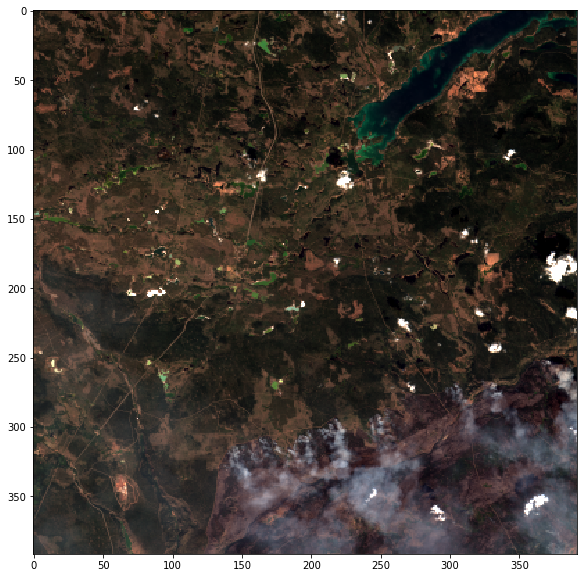

In [0]:
import sys
import time
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_extraction.image import grid_to_graph
import cv2
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

def rescale(arr, two_percent=True):
    """

    """
    arr_min = arr.min()
    arr_max = arr.max()
    scaled = (arr - arr_min) / (arr_max - arr_min)

    if two_percent:
        # 2%-linear stretch transformation for hi-contrast vis
        values = copy.deepcopy(scaled)
        values = values.reshape(np.prod(values.shape))
        values = values.tolist()
        values.sort()
        npx = len(values)  # number of pixels
        if values[-1] < values[0]:
            print('error: failed to sort')
            sys.exit(1)
        v_min = values[int(math.floor(float(npx)*0.02))]
        v_max = values[int(math.floor(float(npx)*0.98))]
        scaled -= v_min
        rng = v_max - v_min
        if rng > 0.:
            scaled /= (v_max - v_min)

    return scaled


if __name__ == "__main__":
    

    drive.mount('/content/gdrive')
    # parse command line arg
    try:
        #!cp '/content/gdrive/My Drive/2019-10-2-111855.png' image
        image = '/content/gdrive/My Drive/sentinel2.bin'   #trying it with the 12 band original image
        #image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin'
        
    # catch no file given
    except IndexError:
        print("Must provide a filename")
        sys.exit(0)

    #with the same image create multiple images
    
    # Read in raster image
    img_ds = gdal.Open(image, gdal.GA_ReadOnly)

    # allocate memory to reshape image
    img = np.zeros((img_ds.RasterYSize,  # number of rows
                    img_ds.RasterXSize,  # number of cols
                    img_ds.RasterCount),  # number of bands
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code

    # reshape the image band by band
    for b in range(img.shape[2]):
        print("reading band", b + 1, "of", img.shape[2])
        print('Band Type: ', img_ds.GetRasterBand(b+1).DataType)
        img[:, :, b] = rescale(np.array(img_ds.GetRasterBand(b + 1).ReadAsArray()))  # normalizing the values for each band using sklearn.preprocessing.normalize, where available norm types are 'l1', 'l2', and 'max', by default the norm is 'l2s'
        # img[:,:, b] = StandardScaler(copy=True, with_mean=True,
        #                     with_std=True).fit_transform(img_ds.GetRasterBand(b + 1).ReadAsArray())
        print('Max value in band', b,' is ', np.amax(img[:,:,b]))


    #Printing the shape of the image
    print(img.shape[0]*img.shape[1])
    print(img.shape[0])
    print(img.shape[1])
    print('Image Raster Count: ', img.shape[2])


    new_img = img[0:392,0:392]  #get sub images out of the original images

    # reshape image again to match expected format for scikit-learn
    new_shape = (392 * 392, img.shape[2])
    X = new_img[:, :, :img.shape[2]].reshape(new_shape)
    print (X.shape[0])


    clr_cropped_img = np.zeros((392, 392, 3))
    for b in range(1,4):
        clr_cropped_img[:, :, 3-b] = new_img[:, :, b]

    plt.figure(figsize=(10,10))
    
    plt.imshow(clr_cropped_img)






Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
reading band 1 of 12
Band Type:  6
Max value in band 0  is  0.16581403
reading band 2 of 12
Band Type:  6
Max value in band 1  is  0.220572
reading band 3 of 12
Band Type:  6
Max value in band 2  is  0.23695904
reading band 4 of 12
Band Type:  6
Max value in band 3  is  0.29423693
reading band 5 of 12
Band Type:  6
Max value in band 4  is  0.2196646
reading band 6 of 12
Band Type:  6
Max value in band 5  is  0.12746935
reading band 7 of 12
Band Type:  6
Max value in band 6  is  0.11573723
reading band 8 of 12
Band Type:  6
Max value in band 7  is  0.11548993
reading band 9 of 12
Band Type:  6
Max value in band 8  is  0.1513658
reading band 10 of 12
Band Type:  6
Max value in band 9  is  0.5494165
reading band 11 of 12
Band Type:  6
Max value in band 10  is  0.15171573
reading band 12 of 12
Band Type:  6
Max value in band 11  is  0.21124534
164410
401
410
Im

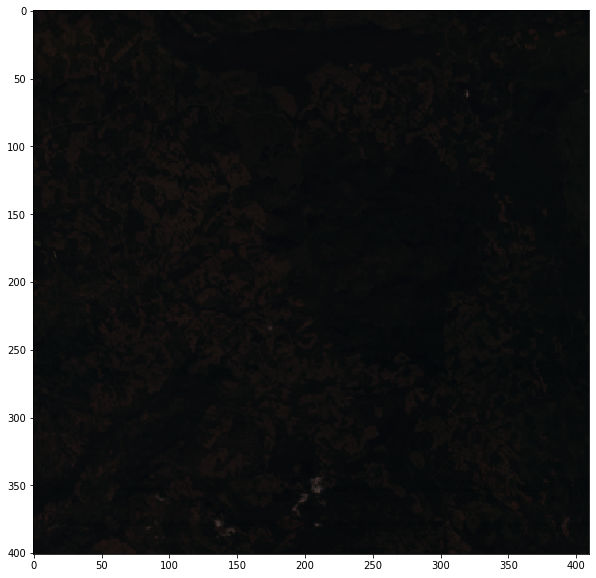

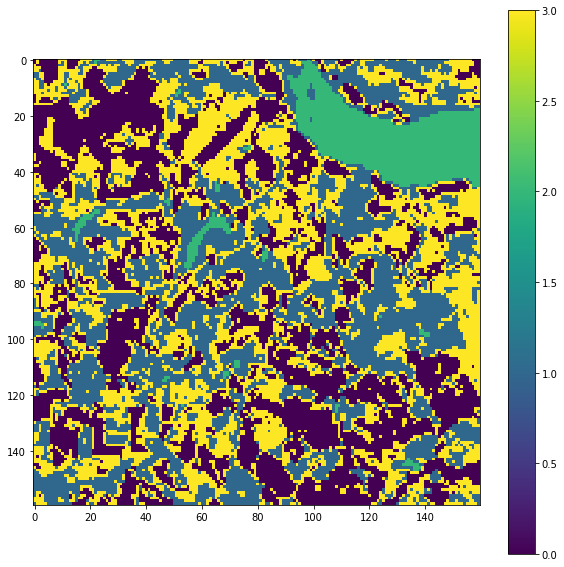

In [0]:

 #Added 10 percent as the distane threshold with random sampling if the new joined cluster size raise up to more than the sub image data
  """
@author: gagandeepbajwa
    based on sattelite-clustering.py by @franama

""" 
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_extraction.image import grid_to_graph
import cv2
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from random import randint
from scipy.spatial import distance_matrix

#colab imorts
from google.colab import drive
from google.colab.patches import cv2_imshow # because cv2 doesnot work in colab

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

#defining gloab data
global_data=[]


#list containing the all the layers created from k-means
individual_layers=[]


broadLeaf_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin"
ccutbl_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CCUTBL_SP.tif_project_4x.bin_sub.bin"
conifer_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/CONIFER_SP.tif_project_4x.bin_sub.bin"
exposed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/EXPOSED_SP.tif_project_4x.bin_sub.bin"
herb_grass_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/HERB_GRAS_SP.tif_project_4x.bin_sub.bin"
mixed_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/MIXED_SP.tif_project_4x.bin_sub.bin"
rivers_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/RiversSP.tif_project_4x.bin_sub.bin"
shrub_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/SHRUB_SP.tif_project_4x.bin_sub.bin"
water_sp="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/WATERSP.tif_project_4x.bin_sub.bin"
vri_s2_objid2="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s2_objid2.tif_project_4x.bin_sub.bin"
vri_s2_objid3="/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/vri_s3_objid2.tif_project_4x.bin_sub.bin"

'''
Function Description: Running heirarchical Clustering on the image

'''
def hierarchical_clustering(image, img, desired_clusters, threshold_1):

    print('Starting executing the heirarchical clustering')
    
    # set parameters for clustering
    n_clusters_desired = desired_clusters # need to experiment with this
    print('Going to run the heirarchical clustering')
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=threshold_1, linkage='ward', compute_full_tree=True) #distance_threshold
    #hierarchical_clustering = AgglomerativeClustering(n_clusters = desired_clusters, linkage='ward') #distance_threshold

    # do the clustering
    hierarchical_clusteringl=hierarchical_clustering.fit(image)

    
    #plotting the dendrogram
    #plot_dendrogram(hierarchical_clustering, image)

    # extract cluster labels and reshape for plotting
    X_cluster = hierarchical_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(10, 10))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()


    # clr_cropped_img = np.zeros((img.shape[0], img.shape[1], 3))
    # for b in range(1,4):
    #     clr_cropped_img[:, :, 3-b] = img[:, :, b]

   # plt.figure(figsize=(10,10))
    
    # plt.imshow(clr_cropped_img)

    # returning the following values: number of clusters, lables, number of trees in the hierarchical tree
    #           number of connected components in the graph
    return hierarchical_clustering.n_clusters, hierarchical_clustering.labels_, hierarchical_clustering.n_leaves_, hierarchical_clustering.n_connected_components_



'''
Function Description: Running the DBSCAN
'''
def dbscan_clustering(image, img):
    
    dbscan_clustering = DBSCAN(eps=0.5, min_samples=10, algorithm= 'ball_tree')

    dbscan_clustering.fit(image)

    X_cluster = dbscan_clustering.labels_
    X_cluster = X_cluster.reshape(img[:, :, 0].shape)

    plt.figure(figsize=(20, 20))
    #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    # Create the colormap
    #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    plt.imshow(X_cluster) #, cmap=cm)
    plt.colorbar()
    plt.show()


'''
Function Description: Creating the colormap of the whole image by providing the cropped clustered data
'''    
def create_color_map(data, originalImageData, img, cropped_size, threshold_2):
    print('Starting creating the color map')

    #initializing the final_labels
    final_labels=data[0][1][:cropped_size]
    final_labels_ = [] #numpy array that will store final labels
    img_ = img
    data_ = data
    originalImageData_ = originalImageData.copy()
    cropped_size_ = cropped_size

    #Run Algorithm to merge the clusters
    merging_algorithm(img_, originalImageData_, final_labels_, data_, threshold_2)
  
'''
Function Description: Plotting Dendogram
'''
def plot_dendrogram(model, X):
    # Create linkage matrix and then plot the dendrogram
    distance, weight = get_distances(X,model)
  
    linkage_matrix = np.column_stack([model.children_, distance, weight]).astype(float)

    plt.figure(figsize=(20,10))
    dendrogram(linkage_matrix)
    plt.show()
    k=randint(0,4)
    plt.savefig('/content/gdrive/My Drive/'+str(k))


'''
Function Description: compute the distance matrix
'''
def get_distances(X,model,mode='actual'):
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d


        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights




'''
Function Description: Run the merging algorithm 
'''
def merging_algorithm(image, cropped_images, final_labels, data, threshold_2, random_sampling=False, centroids=False):
    #LIst of cluster objects
    clusters=[]

    print("data length: ", len(data))
    
    print('Cropped_Images shape:   ', cropped_images[0].shape)

    cluster_nos = []
    indexes_for_clusters = []
    labels_in_cropped = [] #storing labels in the cropped image shape, so it will be easy to join them at the end
    #cropped Size
    cropped_size = 150

    #comparing the cluster objects and deciding whether two cluster objects need to be considered one or not
    for r in range(len(data)): # go through all the elements stored in the data object
        labels = data[r][1] # getting labels for individual cropped images
        #reshaping the labels into the cropped image shape
        labels_cr = labels.reshape(cropped_images[0][ :, :, 0].shape)
        #labels_cr = labels #just here for testing
        labels_in_cropped.append(labels_cr)
        cluster_nos.append(max(labels)) # appending the maximum number in labels means number of clusters in that cropped_image
        for k in range(max(labels)+1): # go through each of the cluster
            np_labels = np.array(labels_cr)
            indexes_f = np.where(np_labels==k) # get all the indexes of the occurrence of specific element in the numpy array
            i_cluster_values_ = []
            indexes = np.array((indexes_f[0], indexes_f[1])).T
           # print(indexes)
            #print(k, ' hello')
            #print('Total number of indexes or values in given cluster: ',len(indexes))
            cropped_image_numbers=[] #for the implementation that each pixel now have individual identity to which cropped image ot belongs
            for ind in range(len(indexes)):
                i_cluster_values_.append(cropped_images[r][indexes[ind][0], indexes[ind][1]])
                cropped_image_numbers.append(r)
               
            i_cluster_values = np.array(i_cluster_values_) #.reshape(cropped_images[0].shape[0]*cropped_images[0].shape[1], cropped_images[0].shape[2])
            #print('cluster_vlaue we got: ', i_cluster_values.shape)
            clusters.append([i_cluster_values, 0]) # append all the cluster objects to the clusters list
            indexes_for_clusters.append([indexes, cropped_image_numbers, k]) # appending all the clusters's index and indexes of all the objects in that cluster we got from running heirarchical clustering on a cropped image

    #printing total number of cluster objects we found
    print("Total Number of clusters found: ",len(clusters))
    print("Maximum number of clusters found in the cropped images: ", max(cluster_nos))
    print(len(clusters[0][0]))

    #labels numbers user
    lnu = []

    #compared
    comparedp = 0

    magic_number = []
    tc=len(clusters)

    for i in range(len(clusters)):
        magic_number.append(i)
    

    #starting comparing the clusters
    #for a in range(len(clusters)):
    a=0
    while a < len(clusters):     
        # print('Number of clusters we have in the list of cluster objects: ', len(clusters))
        comparedp = 0 # re-initialize it to zero for each cluster a 
        for b in range(a,len(clusters)):
           
            if(a!=b and clusters[a][1] != 1 and clusters[b][1]!=1): # processed with the comparison only if both clusters are different
                # print('Going to compare cluster ', a,' and ', b)
                cluster_a = clusters[a][0]
                cluster_b = clusters[b][0]
                a_b = np.concatenate((cluster_a, cluster_b))
                
                #if the length of the combined data is greater than the total number of pixels in the cropped image than take number of pixels that are equal to the total numbe rof pixels in the cropped image
                # if(a_b.shape[0]>cropped_size*cropped_size):
                #   if(cluster_a.shape[0]<(cropped_size*cropped_size)/2 and cluster_a.shape[0]<cluster_b.shape[0]):
                #     rs_cluster_a = cluster_a
                #     rs_cluster_b = cluster_b[np.random.choice(cluster_b.shape[0], int((cropped_size*cropped_size)-cluster_a.shape[0]), replace=False)]
                #   elif(cluster_b.shape[0]<(cropped_size*cropped_size)/2 and cluster_b.shape[0]<cluster_a.shape[0]):
                #     rs_cluster_b = cluster_b
                #     rs_cluster_a = cluster_a[np.random.choice(cluster_a.shape[0], int((cropped_size*cropped_size)-cluster_b.shape[0]), replace=False)]
                #   elif(cluster_a.shape[0]>(cropped_size*cropped_size)/2 and cluster_b.shape[0]>(cropped_size*cropped_size)/2):
                #     rs_cluster_b = cluster_b[np.random.choice(cluster_b.shape[0], int((cropped_size*cropped_size)/2), replace=False)]
                #     rs_cluster_a = cluster_a[np.random.choice(cluster_a.shape[0], int((cropped_size*cropped_size)/2), replace=False)]

                #   #in this scenario we will take maximum cobined cluster's data length equal to the cropped size decided
                #   a_b = np.concatenate((rs_cluster_a, rs_cluster_b))

                #now run the heirarchical clustering
                hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold = threshold_2 , linkage='ward')  #distance threshold has been changed from 25 to 30, need to experiment with it

                # do the clustering
                hierarchical_clustering.fit(a_b)
                        
                # extract cluster labels and reshape for plotting
                cluster = hierarchical_clustering.labels_
                #printing total number of clusters found
                #print(max(cluster))
                percentages=[]#stores the percentages that will give me how much is the overla 
                cluster_percentages=[]
               
                #if we have overlapping clusters we have created the following variables
                new_cluster_values=[]
                new_cluster_indexes=[]

                magic_truth_percentages=[]
                for l in range(max(cluster)+1):
                    count = list(cluster).count(l)
                    total_length = cluster.shape[0]
                    indexes = np.array(np.where(cluster==l)).T #indexes that gets the cluster l   
                    # print('shape of the indexes we got: ', indexes.shape) 

                    #get the new cluster's datapoints to push them into cluster object array for re-comparison
                    new_indexes=[]                 #print(indexes)
                    new_cluster_values_=[]
                    new_cluster_indexes_=[]
                    new_cropped_image_numbers_= []
                    no_in_a=0 
                    for k in indexes:
                      if(k[0]<cluster_a.shape[0]):
                        new_indexes.append([k[0], 0])
                        no_in_a+=1

                      else:
                        new_indexes.append([k[0]-cluster_a.shape[0], 1])#because the final labels we got are on the concated datapoints from two original clusters  
                    
                    for index in new_indexes:
                      
                      if(index[1]==0):
                        new_cluster_values_.append(cluster_a[index[0]])
                        new_cluster_indexes_.append(indexes_for_clusters[a][0][index[0]])
                        new_cropped_image_numbers_.append(indexes_for_clusters[a][1][index[0]])

                      else:
                        new_cluster_values_.append(cluster_b[index[0]])
                        new_cluster_indexes_.append(indexes_for_clusters[b][0][index[0]])
                        new_cropped_image_numbers_.append(indexes_for_clusters[b][1][index[0]])


                      

                    #append new data to the lists holding that data
                    new_cluster_indexes.append([new_cluster_indexes_, new_cropped_image_numbers_])
                    new_cluster_values.append(new_cluster_values_)

                    print(no_in_a)
                    no_in_b = count - no_in_a
                    percentages.append((no_in_b/count)*100)
                    percentages.append((no_in_a/count)*100)
                    cluster_percentages.append((count/total_length)*100)
                    magic_truth_percentages.append((((count/total_length)*100)*((no_in_b/count)*100))/100)
                    # print(',\n\n\n\nNumber of data points that get cluster number ',l, ' is: ', count)
                    # print('Its percentage in the total number of data points: ', (count/total_length)*100)
                    # print('How many percentage of cluster b: ', b,' are ', (no_in_b/count)*100)
                    # print('How many percentage of cluster a: ', a, ' are', (no_in_a/count)*100, '\n\n\n\n')


                #if(max(cluster)>=1):
                # magic_bool=True
                # step=0
                # for i in range(int(len(percentages)/2)):
                #   if(percentages[i+step]>20 or percentages[i+step]>20):
                #     magic_bool= False               
                #   step+=2
                # print(magic_truth_percentages)
                # print(cluster_percentages)
                # print('List of Clusters We have ', magic_number)
                # print('Total Number of clusters:', len(clusters))
                if(max(cluster)>=1):
                  if(max(percentages)==100 and min(percentages)==0 and percentages.count(100)==2 and percentages.count(0)==2):

                      # print('Move on, they are different clusters', a, 'and ', b)
                    
                      #update the label numbers, because their label number may be acquired by some other clusters while merging, do this only when your cluster is unique
                      if(b==magic_number[len(magic_number)-1] and comparedp==0):
                          # print('Cluster Number: ',a,' came out to be a lonely cluster')
                      
                          
                          
                          indexes_vtca = indexes_for_clusters[a][0]
                          values1=[]
                          for values in indexes_vtca:
                              if(len(lnu)==0):
                                  values1.append(0)
                              
                              else:
                                  values1.append(lnu[len(lnu)-1]+1)
                          
                          indlablesa = indexes_vtca
                          for inla in range(len(indexes_vtca)):
                              cropped_imgan = indexes_for_clusters[a][1][inla]
                              labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
                          
                          if(len(lnu)==0):
                            lnu.append(0)
                          
                          else:
                            lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
                            
                          #LIst of new clusters we have
                          # print('List of clusters we have ',lnu)

                  else: #this means the clusters are overlapping
                    tc=tc-2
                    for i in range(max(cluster)+1):
                      #report the flag that these clusters have some noise and should not be compared further                   
                      # print("New Cluster ", i , " got pushed to the clusters object list")
                      clusters.append([np.array(new_cluster_values[i]), 0])
                      indexes_for_clusters.append([new_cluster_indexes[i][0] ,new_cluster_indexes[i][1],  1])
                      #also add the magic number
                      magic_number.append(len(magic_number))
                      tc=tc+1



                    clusters[b][1]=1
                    clusters[a][1]=1

                else:
                    #increment the compared positive
                    tc=tc-2
                    comparedp+=1
                    print('Magic Number: ', magic_number) #informative print
                    clusters[b][1]= 1 #mark the cluster as done because we dont need to compare it with other clusters again
                    clusters[a][1]=1 # because now there combination should be compared instead of individual clusters
                    print('Something is here to think about', a, ' and ', b)
                    indexes_vtca = indexes_for_clusters[a][0] # indexes where values need to be changed
                    

                    indexes_vtcb = indexes_for_clusters[b][0] # indexes where values need to be changed
                   
                
                    
                    values2a=[]
                    for values in indexes_vtca:
                        if(len(lnu)==0):
                            values2a.append(0)
                        
                        else:
                            if(comparedp>1):
                                values2a.append(lnu[len(lnu)-1])
                            
                            else:
                                values2a.append(lnu[len(lnu)-1]+1)
                        
                    
                    values2b=[]
                    for values in indexes_vtcb:
                        if(len(lnu)==0):
                            values2b.append(0)
                        
                        else:
                            if(comparedp>1):
                                values2b.append(lnu[len(lnu)-1])
                            
                            else:
                                values2b.append(lnu[len(lnu)-1]+1)
                    
                    indlablesa = indexes_vtca
                    indlablesb = indexes_vtcb
                    for inla in range(len(indexes_vtca)):
                        cropped_imgan = indexes_for_clusters[a][1][inla]
                        labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values2a[inla]
                    
                    for inlb in range(len(indexes_vtcb)):
                        #print(indexes_for_clusters[b][1][inlb][0])
                        cropped_imgbn = indexes_for_clusters[b][1][inlb]
                        labels_in_cropped[cropped_imgbn][indlablesb[inlb][0], indlablesb[inlb][1]] = values2b[inlb]

                    #pushing the combined cluster
                    clusters.append([np.concatenate((cluster_a, cluster_b)), 0])#push the combined datapoints
                    indexes_for_clusters.append([np.concatenate((indexes_for_clusters[a][0], indexes_for_clusters[b][0])) ,np.concatenate((indexes_for_clusters[a][1], indexes_for_clusters[b][1])),  1])
                    #also add the magic number
                    magic_number.append(len(magic_number))
                    tc=tc+1
                    if(comparedp==1):
                        lnu.append(values2a[0]) # this label number is already used
                    
                    # print('List of clusters we have ',lnu)
                    #magic_number.remove(b) #add removed clusters to the magic_number list

                   
            
            #if the cluster is the last one
            else:
              if(a==magic_number[len(magic_number)-1] and comparedp==0):
                        # print('Cluster Number: ',a,' came out to be a lonely cluster')
                    
                        
                        indexes_vtca = indexes_for_clusters[a][0]
                        values1=[]
                        for values in indexes_vtca:
                            if(len(lnu)==0):
                                values1.append(0)
                            
                            else:
                                values1.append(lnu[len(lnu)-1]+1)
                        
                        indlablesa = indexes_vtca
                        for inla in range(len(indexes_vtca)):
                            cropped_imgan = indexes_for_clusters[a][1][inla]
                            labels_in_cropped[cropped_imgan][indlablesa[inla][0], indlablesa[inla][1]] = values1[inla]
                        
                        
                        if(len(lnu)==0):
                            lnu.append(0)
                          
                        else:
                            lnu.append(lnu[len(lnu)-1]+1) # this label number is already used
                           
                        
                        # print('List of clusters we have ',lnu)

                        break

        a+=1
              
    #       plt.figure(figsize=(7, 7))
    #       #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 0), (0, 1, 1), (0.1, 0.2, 0.5), (0.8, 0.1, 0.3)]
    #       # Create the colormap
    #       #cm = LinearSegmentedColormap.from_list("my map", colors, N=10)
    #       plt.imshow(X_cluster) #, cmap=cm)
    #       plt.colorbar()
    #       plt.show()
                

    #join the cropped labels
    print('------------------------\nStarting Joining the Cropped Images\n----------------- ')
   

    csm = 0
    mastern = 0

    print('labels_in_cropped size: ', len(labels_in_cropped))


    print('Number of clusters found after running merging algorithm: ', len(lnu))


    for master in range(2):
    #     print('Mastern Value is: ', mastern)
        #after the new row is started initialize csm back to 0
        csm=0
        for x in range(cropped_size):
    #         print('x is: ', x)       
            for y in range(2):
    #           print('csm value is: ', csm)
    #           print("csm plus cropped size: ", csm + cropped_size)   
                #showing the cropped image with the new labels
    #           plt.figure(figsize=(5,5))
    #           plt.imshow(labels_in_cropped[y+mastern].reshape(196,196))
                #doing the appending operations
                data_= labels_in_cropped[y+mastern].reshape(cropped_size*cropped_size)  
                final_labels = np.concatenate((final_labels, data_[csm:csm+cropped_size]))
                #size of the final labels
        #           print(final_labels.shape)
                
                if(y==1):# when y i s6 change the csm to add 196 from each image
                    csm=csm+cropped_size
                
            if(x==149):
                    #changing the master number plus 7     
                    mastern = mastern + 2  
    

    print(image.shape)
    print(final_labels.shape)  
    
    #reshaping the final labels
    rfl = final_labels.reshape(300,300)

    print(rfl.shape)  
    
    print('Number of clusters found in the final image', max(final_labels)+1)

    # allocate memory to reshape image
    img_colored = np.zeros((400,  
                    400, 
                    3),  
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code
    

    # for b in range(1,4):
    #     img_colored[:, :, 3-b] = img[0:392, 0:392, b]


    # plt.figure(figsize=(10, 10))
    # plt.imshow(img_colored) #show the colored image for the testing image of size 392, 392

    #plt.savefig('/content/gdrive/My Drive/cropped_img.png')
    # drive.download('cropped_image.png')
    
    #shwing the final image
    plt.figure(figsize=(10, 10))
    plt.imshow(rfl)
    plt.colorbar() 
    for c_no in range(tc):
      create_individual_layer(c_no, rfl)
      compare(water_sp,c_no )
    #plt.savefig('/content/gdrive/My Drive/color_map.png')



'''
Function Description: Visualizing the data
Parameter: Data in particular format
'''
#def visualize(visualization_data):



'''
Function Description: Create an Individual Layer from the generated color map
'''
def create_individual_layer(c_no, colormap):
   colormap_ext =  np.zeros((colormap.shape[0], colormap.shape[1]))
   colormap_ext[:,:] = colormap[:,:]
   for index_x in range(colormap.shape[0]):
     for index_y in range(colormap.shape[1]):
       if(colormap_ext[index_x, index_y]==c_no):
         colormap_ext[index_x, index_y]=1
       
       else:
         colormap_ext[index_x, index_y]=0
   colors = [(0,0,0), (1,1,1)]
   cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
   plt.figure(figsize=(10, 10))
   plt.imshow(colormap_ext, cmap=cm)
  #  plt.imsave(save_colormap_path+str(c_no)+".png", colormap_ext, cmap=cm )
   individual_layers.append(colormap_ext) # append individual layer created to the list, so that it can be used later to compare with the truth data

'''
Function Description: Compare classes created by unsupervised method to the truth data
'''
def compare(layer_type, cluster_n):
    l_ds = readRasterImage(layer_type)
    X, l_img = getInputMatrix(l_ds)
    print(X.shape)
    print(X[0,0])
    water_X=np.zeros((l_img.shape[0], l_img.shape[1]))
    water_X = X.reshape(l_img[:,:,0].shape) #truth_data layer
    layer_k = np.zeros((l_img.shape[0], l_img.shape[1]))
    layer_k = individual_layers[cluster_n] #layer generated from the k_means
    print('Unique values in the given truth layer: ',np.unique(water_X))
    for index_x in range(300):
      for index_y in range(300):
        if(water_X[index_x,index_y]!=128):
          water_X[index_x,index_y]=1
        
        else:
          water_X[index_x,index_y]=0
    colors = [(0,0,0), (1,1,1)]
    cm = LinearSegmentedColormap.from_list("Map", colors, N=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(water_X, cmap=cm)

    #get the stats
    stat(water_X, layer_k)

   

'''
Function Description : Return Stats over the layer generated from K-Means to the the truth data layer 
'''
def stat(truth_layer, generated_layer):
    #counters for the score
    true_positive=0
    true_negative=0
    false_negative=0
    false_positive=0

    for index_x in range(truth_layer.shape[0]):
      for index_y in range(truth_layer.shape[1]):
        if(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==1):
          true_positive+=1
        elif(truth_layer[index_x, index_y]==1 and generated_layer[index_x, index_y]==0):
          false_negative+=1
        elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==1):
          false_positive+=1
        elif(truth_layer[index_x, index_y]==0 and generated_layer[index_x, index_y]==0):
          true_negative+=1

    #compute the stats
    precision = true_positive/(true_positive+false_positive)
    print('Precision is:', precision*100, '%')

    recall = true_positive/(true_positive +false_negative)
    print('Recall is: ', recall*100, '%')

    iou = (true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive)
    print('Accuracy(IOU) is: ', iou*100, '%')

    print('True_Positive: ',true_positive)
    print('False_Positive: ',false_positive)
    print('True_Negative: ',true_negative)
    print('False_Negative: ',false_negative)


'''
Function Description: Splitting the main image
'''
def image_splitter(image, number, threshold_2):
    
    print('Starting the image splitting')
    #showing the original image
    #img=cv2.imread(image)
    img= image;
    #cv2.imshow('output', img) does not work witj colab
   # cv2_imshow(img)
    #cv2.waitKey(0)

    #Getting the size of the image
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    #Size per cropped image
    #cropped_size = int(img.shape[0]/number) # as we have square images, this need to be changed according to the image dimensions

    cropped_size = 150
    # intitializing the array to store all the required information
    data = [];
    
    #initializing the array that will store numpy array objects of the cropped images
    original_data=[]

    #crop starter
    cs = 0
    cj_cs=0
    cj=0
    for i in range(2):
      
        cj=cj_cs
        cj_cs=cj_cs+cropped_size
        
        print('Y star reached ' ,cj)
        
        print('Y end reached ',cj_cs)
        
        #starting again from the left most
        cs=0
        
        for j in range(2):
          
            print('X start reached ', cs)
            
            print('X end reached ', cs+cropped_size)
          
            #cropping down the image
            crop_img = img[ cj:cj_cs,cs:cs+cropped_size ]

            #informative
            print('Number of rows in the cropped image: ',crop_img.shape[0])
            print('Number of columns in the cropped image: ', crop_img.shape[1])
            print('Number of bands in the cropped image: ', crop_img.shape[2])


            #initialize an empty numpy array of cropped image size
            np_crop_img =  np.zeros((crop_img.shape[0],  # number of rows
                            crop_img.shape[1],  # number of cols
                            crop_img.shape[2])  # number of bands
                            )


            #store the image data in the numpy array for reshaping
            for b in range(crop_img.shape[2]):
                np_crop_img[:,:,b] = crop_img[:,:,b]   

            #convert the image to single to numpy array
            new_crop_img_shape = (np_crop_img.shape[0]*np_crop_img.shape[1], np_crop_img.shape[2])
            crop_img_X = np_crop_img[:,:,:np_crop_img.shape[2]].reshape(new_crop_img_shape)
            print(crop_img_X.shape)
                        
            #before running heirarchical clustering find the number of appropriate clusters in the cropped image
            ap_clusters_possible=elbow_method(crop_img_X, 7) #7 is the maximum number of clusters found in the whole image using elbow method

            # showing the cropped image
            #before showing the cropped image we only need 3 bands
            clr_cropped_img = np.zeros((crop_img.shape[0], crop_img.shape[1], 3))
            for b in range(1,4):
              clr_cropped_img[:, :, 3-b] = crop_img[:, :, b]
            
            #display the image
            plt.figure(figsize=(5, 5))
            plt.imshow(clr_cropped_img)
        
            #cv2_imshow(crop_img)

            #Before running the hierachical clustering decide the appropriate distance thereshold you need to cut clusters in each cropped image
            threshold_1 = calculate_threshold(crop_img_X)

            #Runninng hierarchical clustering on the cropped image and  receiving the 
            (n_cluster, lables, n_leaves, n_connected_components )=hierarchical_clustering(crop_img_X, crop_img,7, threshold_1 )

            #pushing the cropped image numpy array to the image_data array
            original_data.append(crop_img)

            #pushing the data to the data array for further interpretation
            data.append((n_cluster, lables, n_leaves, n_connected_components ))

            print('Number of clusters found: ', n_cluster)
            print('Labels: ', lables)
            print('Number of leaves: ', n_leaves)
            print('Number of connected components: ', n_connected_components )

            #increment the crop starter
            cs=cs+cropped_size

            #show the cropped image
            #cv2.imshow("its cropped",crop_img)
            #cv2.waitKey(0)
    

    #printing totla number of clustered cities we get
    print('Total number of different clustered cropped images we got: ', len(data))
    
    #create the color map
    create_color_map(data, original_data, img, cropped_size, threshold_2)



"""
Function Description: calculate threshold
"""
def calculate_threshold(data):
    distances = distance_matrix(data, data)
    print(distances)
    #sorting the distances
    sorted_distances = np.unique(np.sort(distances).reshape(data.shape[0]*data.shape[0]))
    distance_threshold = sorted_distances[int(sorted_distances.shape[0]/2)]
    print(distance_threshold)
    return distance_threshold




"""
Plots number of clusters vs. within cluster sum of squares
(which we aim to minimize)
"""
def elbow_method(image_2d, max_k):
    wcss = []
    for i in range(2, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        random_state=42)
        kmeans.fit(image_2d)
        wcss.append(kmeans.inertia_)

    x = [i for i in range(2, max_k)]
    plt.plot(x, wcss, '--bo')
    plt.xticks(x, x)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    #after plotting the elbow find the corner point


'''
Function Description: Display an imag
'''
def dendogram(f):
    # f =  np.array([[1,1],[3,3],[6,6],[5,5],[10,10], [15,15]])
 #
    hierarchical_clustering = AgglomerativeClustering(n_clusters = None, distance_threshold=6, linkage='ward')
    hierarchical =hierarchical_clustering.fit(f)
    plot_dendrogram(hierarchical, f)


'''
Function Description: Main Function
'''

if __name__ == "__main__":
    

    drive.mount('/content/gdrive')
    # parse command line arg
    try:
        #!cp '/content/gdrive/My Drive/2019-10-2-111855.png' image
        image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/S2A.bin_4x.bin_sub.bin'   #trying it with the 12 band original image
        #image = '/content/gdrive/My Drive/Truth_Data/20190926kamloops_data/BROADLEAF_SP.tif_project_4x.bin_sub.bin'
        
    # catch no file given
    except IndexError:
        print("Must provide a filename")
        sys.exit(0)

    #with the same image create multiple images
    
    # Read in raster image
    img_ds = gdal.Open(image, gdal.GA_ReadOnly)

    # allocate memory to reshape image
    img = np.zeros((img_ds.RasterYSize,  # number of rows
                    img_ds.RasterXSize,  # number of cols
                    img_ds.RasterCount),  # number of bands
                    gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType)) # data type code

    # reshape the image band by band
    for b in range(img.shape[2]):
        print("reading band", b + 1, "of", img.shape[2])
        print('Band Type: ', img_ds.GetRasterBand(b+1).DataType)
        img[:, :, b] = normalize(img_ds.GetRasterBand(b + 1).ReadAsArray(), norm='l2', copy=True)  # normalizing the values for each band using sklearn.preprocessing.normalize, where available norm types are 'l1', 'l2', and 'max', by default the norm is 'l2s'
        # img[:,:, b] = StandardScaler(copy=True, with_mean=True,
        #                     with_std=True).fit_transform(img_ds.GetRasterBand(b + 1).ReadAsArray())
        print('Max value in band', b,' is ', np.amax(img[:,:,b]))


    #Printing the shape of the image
    print(img.shape[0]*img.shape[1])
    print(img.shape[0])
    print(img.shape[1])
    print('Image Raster Count: ', img.shape[2])

    # normalize the data
    # image_ = StandardScaler(copy=True, with_mean=True,
    #                          with_std=True).fit_transform(img)
    #Downsampling the image before reshaping
   #img = img[::2, ::2] + img[1::2, ::2] + img[::2, 1::2] + img[1::2, 1::2]

    #new_img = img[0:400,0:400]  #get sub images out of the original images

    # reshape image again to match expected format for scikit-learn
    new_shape = (img.shape[0] * img.shape[1], img.shape[2])
    X = img[:, :, :img.shape[2]].reshape(new_shape)
    print (X.shape[0])


    clr_cropped_img = np.zeros((img.shape[0], img.shape[1], 3))
    for b in range(1,4):
        clr_cropped_img[:, :, 3-b] = img[:, :, b]

    plt.figure(figsize=(10,10))
    
    plt.imshow(clr_cropped_img)


    

    new_img = np.zeros((160,160, 12))
    new_img =  img[:160, :160]
    new_X = new_img[:, :, :new_img.shape[2]].reshape(160*160,12)
    #running the hierarchical clustering
    hierarchical_clustering(new_X, new_img,7, 3)

    #runnig the DBSCAN
    #dbscan_clustering(X, img)

    #running image splitting
    #image_splitter(image, 7)
    #image_splitter(img,7, 3)
    #image_splitter(new_img, 7)
    # f =  np.array([[1,1],[3,3],[6,6],[5,5],[10,10], [15,15]])
    # f1 = np.array([[1,1],[6,6],[10,10],[15,15]])
    # f2 = np.array([[3,3],[5,5]])
    # dendogram(f)
    # dendogram(f1)
    # dendogram(f2)
    # f1f2 = np.array([[15,15],[1,1]])
    # f1f3 = np.array([[15,15],[6,6], [10,10]])
    # f1f4 = np.array([[15,15],[3,3],[5,5]])
    # dendogram(f1f2)
    # dendogram(f1f3)
    # dendogram(f1f4)
    # f2f3 = np.array([[1,1],[6,6],[10,10]])
    # f2f4 = np.array([[1,1], [3,3], [5,5]])
    # dendogram(f2f3)
    # dendogram(f2f4)
    # f3f4 = np.array([[6,6],[15,15],[3,3],[5,5],[1,1]])
    # dendogram(f3f4)


